In [155]:
import numpy as np
import pandas as pd
import paranoid as pns
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import interpolate, optimize

import ddm
import ddm.plot
import paranoid as pns
pns.settings.Settings.set(enabled=False)

# pyddm simulation

In [191]:
class DriftTta(ddm.Drift):
    name = 'Drift depends on time and critical TTA (parameter)'
    required_parameters = ['alpha', 'tta_crit']
    required_conditions = ['tta_condition'] 
    
    def get_drift(self, t, conditions, **kwargs):
        current_tta = conditions['tta_condition'] - t
        return self.alpha*(current_tta - self.tta_crit)

In [151]:
def model_error_wls_per_condition(model, solution, exp_measures):
    # weighted least squares error, as described in Ratcliff & Tuerlinckx 2002   
    p_exp = exp_measures.is_turn_decision.mean()
    delta_p = (solution.prob_correct() - p_exp)**2

    t = model.t_domain()
    model_cdf = solution.cdf_corr()
    model_cdf = interpolate.interp1d(t, model_cdf/model_cdf[-1])
    rt_quantiles = [0.1, 0.3, 0.5, 0.7, 0.9]
    model_rt_quantiles = [optimize.root_scalar(lambda x:model_cdf(x)-quantile, bracket=(0, t[-1])).root 
                          for quantile in rt_quantiles]
    exp_rt_quantiles = exp_measures[exp_measures.is_turn_decision].RT.quantile(rt_quantiles)        

    rt_q_weights = [2, 2, 1, 1, 0.5]
    return 4*delta_p + np.dot((model_rt_quantiles-exp_rt_quantiles)**2, rt_q_weights)*p_exp

def model_error_wls(model, exp_measures):
    error = [model_error_wls_per_condition(model, model.solve(conditions={'tta_condition': tta_condition}),
                                           exp_measures[exp_measures.tta_condition==tta]) for tta_condition in [4, 5, 6]]
    return sum(error)

def f_wls(params):
    alpha, boundary, tta_crit = params
    model = ddm.Model(drift=DriftTta(alpha=alpha, tta_crit=tta_crit),
              noise=ddm.NoiseConstant(noise=1.0),
              bound=ddm.BoundConstant(B=boundary), T_dur=2.5)

    exp_measures = pd.read_csv('measures.csv')
    f = model_error_wls(model, exp_measures)
    print(f, params)
    return f

In [140]:
%time f_wls([1.1, 1.1, 4.5])

0.3721796601762972 [1.1, 1.1, 4.5]
Wall time: 22 s


0.3721796601762972

### Testing loss function

In [295]:
WLS = 0
for comb in exp_sample.condition_combinations():
    print(comb)
    comb_sample = exp_sample.subset(**comb)
    sol = fit_model.solve(conditions=comb)
    p_diff = 4*(sol.prob_correct() - comb_sample.prob_correct())**2
#     p_diff = sol.prob_correct() - comb_sample.prob_correct()
    print ('p_correct_model', sol.prob_correct())
    print ('p_correct_exp', comb_sample.prob_correct())
    WLS += p_diff    
print(WLS)

{'tta_condition': 4}
p_correct_model 0.23593073816915025
p_correct_exp 0.22794117647058823
{'tta_condition': 5}
p_correct_model 0.42051365115865974
p_correct_exp 0.44074074074074077
{'tta_condition': 6}
p_correct_model 0.6368953474180773
p_correct_exp 0.6282527881040892
0.0021906483223698464


In [347]:
rt_quantiles = [0.1, 0.3, 0.5, 0.7, 0.9]
rt_q_weights = [2, 2, 1, 1, 0.5]

def get_rt_quantiles(x, t_domain, exp=False):
    cdf = x.cdf_corr(T_dur=2.5, dt=0.002) if exp else x.cdf_corr()
    cdf_interp = interpolate.interp1d(t_domain, cdf/cdf[-1])
    rt_quantile_values = [optimize.root_scalar(lambda x:cdf_interp(x)-quantile, bracket=(0, t_domain[-1])).root
                          for quantile in rt_quantiles]
    return np.array(rt_quantile_values)    
    
WLS = 0
for comb in exp_sample.condition_combinations():
    print(comb['tta_condition'])
    comb_sample = exp_sample.subset(**comb)
    sol = fit_model.solve(conditions=comb)
    model_rt_q = get_rt_quantiles(sol, fit_model.t_domain(), exp=False)
    exp_rt_q = get_rt_quantiles(comb_sample, fit_model.t_domain(), exp=True)
    rt_diff = np.dot((model_rt_q-exp_rt_q)**2, rt_q_weights)*comb_sample.prob_correct()
    print(rt_diff)
    WLS += rt_diff
print(WLS)

4
0.006974733613078374
5
0.007828225188534975
6
0.010818327492281985
0.025621286293895335


### Fitting using pyddm

In [244]:
class LossByMeans(LossFunction):
    name = "Mean correct RT and accuracy"
    def setup(self, dt, T_dur, **kwargs):
        self.dt = dt
        self.T_dur = T_dur
        self.exp_data = pd.read_csv('measures.csv', usecols=['RT', 'is_turn_decision', 'tta_condition'])
        
    def loss(self, model):
        sols = self.cache_by_conditions(model)
        MSE = 0
        for comb in self.sample.condition_combinations(required_conditions=self.required_conditions):
            c = frozenset(comb.items())
            mean_rt_exp_cor = self.exp_data[self.exp_data.tta_condition == comb['tta_condition']].RT.mean()
            comb_sample = self.sample.subset(**comb)
            MSE += (sols[c].prob_correct() - comb_sample.prob_correct())**2
            if sols[c].prob_correct() > 0:
                MSE += (sols[c].mean_decision_time() - mean_rt_exp_cor)**2
        return MSE
    
class LossWLS(ddm.LossFunction):
    name = 'Weighted least squares as described in Ratcliff & Tuerlinckx 2002'
    rt_quantiles = [0.1, 0.3, 0.5, 0.7, 0.9]
    rt_q_weights = [2, 2, 1, 1, 0.5]
    
    def setup(self, dt, T_dur, **kwargs):
        self.dt = dt
        self.T_dur = T_dur
    
    def get_rt_quantiles(self, x, t_domain, exp=False):
        cdf = x.cdf_corr(T_dur=self.T_dur, dt=self.dt) if exp else x.cdf_corr()
        cdf_interp = interpolate.interp1d(t_domain, cdf/cdf[-1])
        rt_quantile_values = [optimize.root_scalar(lambda x:cdf_interp(x)-quantile, bracket=(0, t_domain[-1])).root
                              for quantile in self.rt_quantiles]
        return np.array(rt_quantile_values)
    
    def loss(self, model):
        sols = self.cache_by_conditions(model)
        WLS = 0
        for comb in self.sample.condition_combinations(required_conditions=self.required_conditions):
            c = frozenset(comb.items())
            comb_sample = self.sample.subset(**comb)
            WLS += 4*(sols[c].prob_correct() - comb_sample.prob_correct())**2
            if sols[c].prob_correct() > 0:
                model_rt_q = self.get_rt_quantiles(sols[c], model.t_domain(), exp=False)
                exp_rt_q = self.get_rt_quantiles(comb_sample, model.t_domain(), exp=True)
                WLS += np.dot((model_rt_q-exp_rt_q)**2, self.rt_q_weights)*comb_sample.prob_correct()
        return WLS

In [218]:
exp_data = pd.read_csv('measures.csv', usecols=['RT', 'is_turn_decision', 'tta_condition'])
exp_sample = ddm.Sample.from_pandas_dataframe(df=exp_data, rt_column_name='RT', correct_column_name='is_turn_decision')

In [220]:
model_tta = ddm.Model(name='Model with drift depending on TTA',
                 drift=DriftTta(alpha=ddm.Fittable(minval=0.1, maxval=5), 
                                tta_crit=ddm.Fittable(minval=2, maxval=6)),
                 noise=ddm.NoiseConstant(noise=1),
                 bound=ddm.BoundConstant(B=ddm.Fittable(minval=.1, maxval=3.0)),
                 overlay=ddm.OverlayNonDecision(nondectime=ddm.Fittable(minval=0, maxval=.5)),
                 T_dur=2.5)

In [245]:
%time fit_model = ddm.fit_adjust_model(sample=exp_sample, model=model_tta, lossfunction=LossWLS)

[2.1922732209915603, 4.495667937328644, 1.7619992356226026, 0.07717394148724588]
2.274629480619214
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(4.126871767282851, minval=0.1, maxval=5), tta_crit=Fitted(3.6095627036048485, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(2.000392016067175, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.1334822741216527, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.274629480619214
2.322920425140577
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(1.051886934710509, minval=0.1, maxval=5), tta_crit=Fitted(3.31998334011631, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.4049799729558043, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.36011679614661296, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.3

1.0852559706985336
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(2.9312692677356704, minval=0.1, maxval=5), tta_crit=Fitted(4.248816414073655, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.1510072520075902, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.16523241560342303, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.0852559706985336
4.3620980212928835
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(3.847696809143066, minval=0.1, maxval=5), tta_crit=Fitted(2.8848962756714496, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5267510129677988, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.3972040437841891, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=4.3620980212928835
2.556204759583542
Model(name='Model with drift depending on

4.557939118190706
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(1.7728015806746815, minval=0.1, maxval=5), tta_crit=Fitted(2.3714394120742317, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.6559077852196746, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.49238261826594754, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=4.557939118190706
2.509640682862446
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(4.7697801557342325, minval=0.1, maxval=5), tta_crit=Fitted(5.099036306453557, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(2.2605506620891824, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.4820064154777178, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.509640682862446
3.9008103595193266
Model(name='Model with drift depending on T

2.129448138999455
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(3.0950368429553343, minval=0.1, maxval=5), tta_crit=Fitted(3.7493565940609725, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.7063500793823171, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.31614327589534025, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.129448138999455
2.0694226781364224
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(4.974159410523454, minval=0.1, maxval=5), tta_crit=Fitted(5.52051956207712, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6627407953583254, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.04043482108277094, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.0694226781364224
4.983749732217495
Model(name='Model with drift depending on T

2.1927497753808023
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(2.605987491777901, minval=0.1, maxval=5), tta_crit=Fitted(4.730819132706591, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.25924120242592164, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.023693060503639007, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.1927497753808023
2.1500052137624417
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.92432470193863, minval=0.1, maxval=5), tta_crit=Fitted(4.348315703905258, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.3598001608259942, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.3761625960359934, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.1500052137624417
3.1355586814290697
Model(name='Model with drift depending on

0.6666722456713488
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(1.366287140045305, minval=0.1, maxval=5), tta_crit=Fitted(4.239282255601957, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.3694233163953766, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.46898429982880796, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.6666722456713488
5.97532500477479
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(2.610243958541858, minval=0.1, maxval=5), tta_crit=Fitted(5.100380266779264, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(2.8513655264663633, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.46624834470662624, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=5.97532500477479
3.9226321255098155
Model(name='Model with drift depending on TTA

1.8133236056878645
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(3.4509469253841516, minval=0.1, maxval=5), tta_crit=Fitted(5.16882636709519, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.779256615415692, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.3791465036815671, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.8133236056878645
4.415237965210417
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(4.182784521895117, minval=0.1, maxval=5), tta_crit=Fitted(2.6589793516904523, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(2.2975120836276464, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.204257437503641, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=4.415237965210417
5.78962645386593
Model(name='Model with drift depending on TTA', 

3.1934027888233807
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(1.3330952069677207, minval=0.1, maxval=5), tta_crit=Fitted(3.7493565940609725, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.9476071060516291, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.3716809401660916, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=3.1934027888233807
0.7363748308673899
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.36204001469577207, minval=0.1, maxval=5), tta_crit=Fitted(3.421201273207112, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.8131925120173988, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.04043482108277094, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.7363748308673899
2.7016942386097855
Model(name='Model with drift depending

2.393638395416555
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(3.682063746252185, minval=0.1, maxval=5), tta_crit=Fitted(5.4380307822252085, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.6688918760115343, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.4294699494290406, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.393638395416555
1.087068926587853
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.232168732401957, minval=0.1, maxval=5), tta_crit=Fitted(3.454039736680236, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.024796983548305, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.17162103372164522, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.087068926587853
differential_evolution step 1: f(x)= 0.179857
1.1353365796823005


3.203217197471939
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.820454659215593, minval=0.1, maxval=5), tta_crit=Fitted(2.2346198042887044, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5888870650195895, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.16523241560342303, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=3.203217197471939
1.0098904787656255
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(3.2841307352683438, minval=0.1, maxval=5), tta_crit=Fitted(5.275351391371309, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.1488979752299973, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.28461874671234344, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.0098904787656255
1.024176309794484
Model(name='Model with drift depending on 

1.2270214555109489
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7639513105012397, minval=0.1, maxval=5), tta_crit=Fitted(5.820767017442207, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.7723190500172458, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.49238261826594754, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.2270214555109489
3.3074336623424316
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.6834264631493245, minval=0.1, maxval=5), tta_crit=Fitted(5.099036306453557, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.3815764212660246, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.39583089860377974, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=3.3074336623424316
0.7650145622471789
Model(name='Model with drift depending 

1.6450223261767292
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(3.0950368429553343, minval=0.1, maxval=5), tta_crit=Fitted(4.093731840102886, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.8444337958036534, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2649806888981624, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.6450223261767292
0.6141679744839591
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.36204001469577207, minval=0.1, maxval=5), tta_crit=Fitted(3.421201273207112, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.2801602775647638, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.49408849664591004, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.6141679744839591
3.357150187331762
Model(name='Model with drift depending o

0.29109071996484004
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(1.37031371560916, minval=0.1, maxval=5), tta_crit=Fitted(5.005880941629885, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6627323943352166, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.39266030262513896, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.29109071996484004
1.232438917160776
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.232168732401957, minval=0.1, maxval=5), tta_crit=Fitted(4.257656224537355, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.024796983548305, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.24143893131827468, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.232438917160776
differential_evolution step 2: f(x)= 0.179857
1.05482717425702

1.0848806727800302
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(2.578309332387877, minval=0.1, maxval=5), tta_crit=Fitted(5.492424558857467, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.8527182807897734, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.1398678424991875, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.0848806727800302
1.0321050949765223
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(2.504807889817101, minval=0.1, maxval=5), tta_crit=Fitted(5.389008971835082, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.8292336011671207, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.4406755984058924, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.0321050949765223
1.4466512101642002
Model(name='Model with drift depending on T

1.1906870792069695
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(2.1613022589399105, minval=0.1, maxval=5), tta_crit=Fitted(5.451890202138255, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.8573806728538051, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.4627679915089041, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.1906870792069695
0.49815507391563707
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.5127857582970226, minval=0.1, maxval=5), tta_crit=Fitted(4.88789176972655, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.7233231773890226, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.4296210019358376, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.49815507391563707
2.2032999754751366
Model(name='Model with drift depending o

0.4482115067946988
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(1.541778730620253, minval=0.1, maxval=5), tta_crit=Fitted(5.755411368700887, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.38487998253115174, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.3198290793708803, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.4482115067946988
0.4001576147393806
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.6990776521845203, minval=0.1, maxval=5), tta_crit=Fitted(4.908562500538746, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.27081749438327174, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.3700134322449672, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.4001576147393806
0.05806646514618813
Model(name='Model with drift depending 

1.5153330665561948
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(3.4562702477554916, minval=0.1, maxval=5), tta_crit=Fitted(4.4734924888551735, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6361411445839129, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.16441041226714578, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.5153330665561948
0.5754697508029218
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(1.4630809971924843, minval=0.1, maxval=5), tta_crit=Fitted(5.110867935972173, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.9429277653997875, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2767942663345644, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.5754697508029218
0.46890421948822814
Model(name='Model with drift depending

1.1103126847117857
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(4.755246596187472, minval=0.1, maxval=5), tta_crit=Fitted(4.993990937657438, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.3254288409231738, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2607167057113088, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.1103126847117857
1.1431375208707069
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(2.504807889817101, minval=0.1, maxval=5), tta_crit=Fitted(4.672983125715632, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.7095703515029931, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.09663378269380013, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.1431375208707069
1.0879361535432241
Model(name='Model with drift depending on 

0.2567092542664086
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(1.7585434995606508, minval=0.1, maxval=5), tta_crit=Fitted(5.22408714062299, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5033378731677767, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.3863343156941377, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.2567092542664086
0.41792606029904894
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.5141252388224924, minval=0.1, maxval=5), tta_crit=Fitted(5.430072929920962, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.7771943432076373, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.33808276168980633, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.41792606029904894
0.47577655628775367
Model(name='Model with drift depending

0.527377609208947
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(2.8526555118364048, minval=0.1, maxval=5), tta_crit=Fitted(4.997769831518015, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.42050779138458627, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.44340342713683195, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.527377609208947
3.772773477821687
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(3.072300824199774, minval=0.1, maxval=5), tta_crit=Fitted(3.471878852138749, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6119037540877219, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.09856422991293365, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=3.772773477821687
1.3805453141125343
Model(name='Model with drift depending on T

1.810016768592269
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.6797411996675717, minval=0.1, maxval=5), tta_crit=Fitted(4.562608562953807, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.315674868072378, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.032811457715666154, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.810016768592269
0.7298173028164369
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.5011347202297074, minval=0.1, maxval=5), tta_crit=Fitted(4.820034361733029, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.0838815181371109, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.17162103372164522, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.7298173028164369
differential_evolution step 4: f(x)= 0.0580665
1.09091023671

0.9103372194518489
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(2.58315859733428, minval=0.1, maxval=5), tta_crit=Fitted(5.196304571715102, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.1510072520075902, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.13572785618360012, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.9103372194518489
1.1928937151940475
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(1.2927441393245764, minval=0.1, maxval=5), tta_crit=Fitted(5.275351391371309, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.1488979752299973, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.28461874671234344, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.1928937151940475
0.791239503558318
Model(name='Model with drift depending on 

0.88272004682449
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(2.4349977084336776, minval=0.1, maxval=5), tta_crit=Fitted(5.295578847313571, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.920468794920232, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.33808276168980633, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.88272004682449
0.7357064094578841
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(1.122856500722031, minval=0.1, maxval=5), tta_crit=Fitted(5.754255478329085, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.7723190500172458, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2404072866823652, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.7357064094578841
0.33947066472833654
Model(name='Model with drift depending on TTA

2.112317073224154
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(3.8065906224315524, minval=0.1, maxval=5), tta_crit=Fitted(4.424534007787697, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6504704136680567, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.07484193451995619, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.112317073224154
0.8626058153649397
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(2.006664977644249, minval=0.1, maxval=5), tta_crit=Fitted(4.367351911454311, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.1188552322763294, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.043252401095245196, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.8626058153649397
0.22760230887468796
Model(name='Model with drift depending o

0.5430235106380266
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(1.5160196230468421, minval=0.1, maxval=5), tta_crit=Fitted(4.860061064950762, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.7763545932651894, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.08261474306262678, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.5430235106380266
0.3149936510668021
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(1.230262803469276, minval=0.1, maxval=5), tta_crit=Fitted(5.0868087292690385, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.430923662460037, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.24333930647513924, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.3149936510668021
0.8536356489112148
Model(name='Model with drift depending o

1.2853810882300918
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.19244204473613102, minval=0.1, maxval=5), tta_crit=Fitted(4.757005365426629, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.198866366677474, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.0419415708641864, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.2853810882300918
0.20052580553148475
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.5924568651554563, minval=0.1, maxval=5), tta_crit=Fitted(4.552736082450893, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.7853182952509404, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.06087379908381535, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.20052580553148475
0.7194188534399488
Model(name='Model with drift depending

0.38333862407412445
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(2.270380521746899, minval=0.1, maxval=5), tta_crit=Fitted(4.782004861971334, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.21461993217280906, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.43465441497582125, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.38333862407412445
2.090147093102834
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(4.6532317545858835, minval=0.1, maxval=5), tta_crit=Fitted(4.4261269688677025, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5722348216559288, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.1611856284753295, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.090147093102834
0.3840202785621289
Model(name='Model with drift depending 

0.4867565308452041
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.30101973362330936, minval=0.1, maxval=5), tta_crit=Fitted(4.9890183816571385, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6417619084270954, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.4491956094392836, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.4867565308452041
0.3235060161762319
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.3286496464014226, minval=0.1, maxval=5), tta_crit=Fitted(4.69235604777224, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.9511288286512976, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.05228630689690847, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.3235060161762319
0.6309664910712522
Model(name='Model with drift depending 

0.35936072460364743
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.9611334235302487, minval=0.1, maxval=5), tta_crit=Fitted(5.095543178781464, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.7772593266757284, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.3603452813133501, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.35936072460364743
0.04280792977662605
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7459460855268354, minval=0.1, maxval=5), tta_crit=Fitted(5.166593723602528, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6474745573697008, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.27358744922988393, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.04280792977662605
0.185644756520881
Model(name='Model with drift dependin

0.5009838557793118
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7801820118306229, minval=0.1, maxval=5), tta_crit=Fitted(4.710587964100229, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.8811303650574299, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.3344576936691018, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.5009838557793118
0.22325772099974484
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.29973051956162733, minval=0.1, maxval=5), tta_crit=Fitted(5.164749739192266, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5510614606343526, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.22569443174390927, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.22325772099974484
0.12365173469350807
Model(name='Model with drift dependi

1.1042662658767501
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.751621131524439, minval=0.1, maxval=5), tta_crit=Fitted(5.577956895754063, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.019488744754431, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2646618634019793, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.1042662658767501
0.2028672199530342
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.6051604960657029, minval=0.1, maxval=5), tta_crit=Fitted(5.309526683781709, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.45631323999181506, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2714513994101818, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.2028672199530342
0.24139121193550594
Model(name='Model with drift depending on

0.4219006005114315
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.45694772371434533, minval=0.1, maxval=5), tta_crit=Fitted(5.232957037659975, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.8193777266389176, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.3092505864937846, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.4219006005114315
differential_evolution step 7: f(x)= 0.0397077
0.0580999491320445
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.637004664147768, minval=0.1, maxval=5), tta_crit=Fitted(5.107303707324166, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.7057629656736047, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.256841284511695, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.0580999491320445
0.314405530089

0.11611033910623716
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.6323187834697706, minval=0.1, maxval=5), tta_crit=Fitted(5.110894952795518, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.7724990073536696, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.23821827530205447, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.11611033910623716
0.10697321318404719
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7881626159506614, minval=0.1, maxval=5), tta_crit=Fitted(5.281379679085239, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6679130217927602, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.20794966557777442, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.10697321318404719
0.25319078110606696
Model(name='Model with drift depen

0.9091900014145586
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8441310525404535, minval=0.1, maxval=5), tta_crit=Fitted(4.4261269688677025, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.4828482577938946, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.1012684543861273, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.9091900014145586
0.10891936565082044
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7578434682398036, minval=0.1, maxval=5), tta_crit=Fitted(5.295137785806593, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.4399335628546399, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.3523184850987492, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.10891936565082044
0.25663915940204546
Model(name='Model with drift dependin

1.3228470071701741
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(3.992251924687599, minval=0.1, maxval=5), tta_crit=Fitted(4.461580990638375, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.9633822378942533, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.12531350291222196, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.3228470071701741
0.7259477576355386
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.5995213860207229, minval=0.1, maxval=5), tta_crit=Fitted(5.303690021129393, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.0731903265803864, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.12946662687774005, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.7259477576355386
0.9086278869696502
Model(name='Model with drift depending o

0.12153606377524451
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.5912950618269623, minval=0.1, maxval=5), tta_crit=Fitted(4.991299818515039, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.704642292947298, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.12082264088731204, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.12153606377524451
0.0983564380457108
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7634375640296924, minval=0.1, maxval=5), tta_crit=Fitted(5.4767105705224095, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5447577786797286, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.3043890868392579, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.0983564380457108
0.09891259099488989
Model(name='Model with drift dependin

0.1999748806106745
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.6622988530760974, minval=0.1, maxval=5), tta_crit=Fitted(5.157537092595993, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6073914256680446, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.14606035493933528, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1999748806106745
0.2147017640107946
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.554955620466989, minval=0.1, maxval=5), tta_crit=Fitted(4.774841662957299, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.4411902684808371, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.43569703517952596, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.2147017640107946
0.2437490861977371
Model(name='Model with drift depending o

0.26121589310903365
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(1.3187437303770448, minval=0.1, maxval=5), tta_crit=Fitted(5.147335923060107, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5114789529899963, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.4891356206160625, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.26121589310903365
0.08933156734876614
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.6448928375277423, minval=0.1, maxval=5), tta_crit=Fitted(5.170028540657915, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.758718838439974, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.1794417634477395, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.08933156734876614
0.07056486606706924
Model(name='Model with drift dependin

0.07086222147245473
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.6737562493165807, minval=0.1, maxval=5), tta_crit=Fitted(5.235242782799316, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6147773452474123, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.3440123036768557, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.07086222147245473
0.13742355323541636
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7164539730400357, minval=0.1, maxval=5), tta_crit=Fitted(5.239654098763079, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.65489805159082, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.16301447269298666, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.13742355323541636
0.3430441800867044
Model(name='Model with drift depending

0.12698694686291703
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.42437292756854106, minval=0.1, maxval=5), tta_crit=Fitted(5.209590181408404, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5653353377892855, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.23838573799411994, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.12698694686291703
0.16190976920088646
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8067482056353628, minval=0.1, maxval=5), tta_crit=Fitted(4.852336469687543, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.4801777303736934, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.4464209175056587, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.16190976920088646
0.3638173716949645
Model(name='Model with drift depend

0.053493577561141724
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7066039769806864, minval=0.1, maxval=5), tta_crit=Fitted(4.836073671207549, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.720541484769531, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.243495788670266, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.053493577561141724
0.04642986815699733
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.6780926970576096, minval=0.1, maxval=5), tta_crit=Fitted(4.806077578181872, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6934123687740325, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.23529271824692813, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.04642986815699733
0.10144631381692686
Model(name='Model with drift depend

0.1708210996998992
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8186016038171862, minval=0.1, maxval=5), tta_crit=Fitted(4.608021913255681, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5972845635640455, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.36373943980419754, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1708210996998992
0.23356346332554162
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.9342301397466022, minval=0.1, maxval=5), tta_crit=Fitted(5.617946174758346, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.26552428244999615, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.47130398228720055, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.23356346332554162
0.04178390152222676
Model(name='Model with drift depend

0.06924135482949606
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.5221413770309957, minval=0.1, maxval=5), tta_crit=Fitted(5.009010302071304, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.7152463723113208, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.24916501185680542, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.06924135482949606
0.07750009844667671
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.6570329255307299, minval=0.1, maxval=5), tta_crit=Fitted(5.2282238630115705, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5700993316631585, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.37421259720309735, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.07750009844667671
0.03343648753962337
Model(name='Model with drift depe

0.03644466992683519
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7059798968950659, minval=0.1, maxval=5), tta_crit=Fitted(5.149769822852387, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6409817047491714, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2777764408632387, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03644466992683519
0.04163171822899399
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.6584469460805835, minval=0.1, maxval=5), tta_crit=Fitted(4.996049516643443, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6274328044124161, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.23655341067881253, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.04163171822899399
0.3179208343781378
Model(name='Model with drift dependi

0.0944813665026778
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.5907447283433072, minval=0.1, maxval=5), tta_crit=Fitted(5.332369887301981, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.49305502082407315, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.3255224967056885, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.0944813665026778
0.06654150302042287
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.5348333521315833, minval=0.1, maxval=5), tta_crit=Fitted(4.787768961956131, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.728863533786562, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.21367977382376335, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.06654150302042287
0.05542731711968835
Model(name='Model with drift dependin

0.04345367302099794
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7506495977707919, minval=0.1, maxval=5), tta_crit=Fitted(5.214958967939365, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5736117003505959, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2945786618028688, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.04345367302099794
0.13232104820993623
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.89313289527688, minval=0.1, maxval=5), tta_crit=Fitted(4.889374872599905, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.46456292146184786, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.3288202563152888, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.13232104820993623
0.06448923571390273
Model(name='Model with drift dependin

0.16307649546024594
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.3434143551169533, minval=0.1, maxval=5), tta_crit=Fitted(5.2933321832337725, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.56204738427473, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.23897552355399432, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.16307649546024594
0.15775363994653901
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.6410674994317886, minval=0.1, maxval=5), tta_crit=Fitted(5.328800569011048, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.7176013744686286, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.137275174230933, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.15775363994653901
0.324042858175741
Model(name='Model with drift depending 

0.18822172285849081
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.5956118294022399, minval=0.1, maxval=5), tta_crit=Fitted(4.716487960973065, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.4579446495902233, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.3913639195958592, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.18822172285849081
0.06664680883621138
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7799596989762261, minval=0.1, maxval=5), tta_crit=Fitted(5.335450385982799, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5696351904327996, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.34126139950345985, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.06664680883621138
0.03681396010708626
Model(name='Model with drift depend

0.09478235827872192
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7631265723593263, minval=0.1, maxval=5), tta_crit=Fitted(5.422924096942525, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.489296668693026, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.4016209772486606, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.09478235827872192
0.052957508031284316
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.9031774958253924, minval=0.1, maxval=5), tta_crit=Fitted(5.070971773224616, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5811339735417782, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.34581893226789656, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.052957508031284316
0.06023007417121941
Model(name='Model with drift depen

0.03287911789914043
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.6682167551769416, minval=0.1, maxval=5), tta_crit=Fitted(5.135558098480377, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6312930620960961, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2619247400417565, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03287911789914043
0.03850537396676167
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.6889332224852183, minval=0.1, maxval=5), tta_crit=Fitted(4.90178554762052, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6205340773532024, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2898043672880274, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03850537396676167
0.041000476825358456
Model(name='Model with drift dependi

0.051274064744545204
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.6349188256124221, minval=0.1, maxval=5), tta_crit=Fitted(4.895283259492413, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.7328690734017803, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.17548422460216023, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.051274064744545204
0.08120864730555824
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.6639994282769022, minval=0.1, maxval=5), tta_crit=Fitted(4.7937179794000295, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6793879898132097, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.17934685094773814, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.08120864730555824
0.06373329715245768
Model(name='Model with drift de

0.11110889747440642
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.6306462068595271, minval=0.1, maxval=5), tta_crit=Fitted(5.163890321485642, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.759158969684882, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.24290073576310517, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.11110889747440642
0.06432134521569899
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.6635303358133378, minval=0.1, maxval=5), tta_crit=Fitted(4.949952181912353, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5972845635640455, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.23814946706450957, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.06432134521569899
0.26004047262551777
Model(name='Model with drift depend

0.03551073771384263
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7978183592009211, minval=0.1, maxval=5), tta_crit=Fitted(4.979888877571954, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6591391160358293, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2601417603733339, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03551073771384263
0.055178162301859394
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7331950996545178, minval=0.1, maxval=5), tta_crit=Fitted(5.2282238630115705, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5700993316631585, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.3539770912203774, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.055178162301859394
0.0471603689078187
Model(name='Model with drift depen

0.04158668384613811
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.693050452483738, minval=0.1, maxval=5), tta_crit=Fitted(5.149769822852387, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6576525487646468, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2777764408632387, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.04158668384613811
0.09244380351729384
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7863226011431759, minval=0.1, maxval=5), tta_crit=Fitted(4.915858509048754, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5760102210456671, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.23655341067881253, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.09244380351729384
0.03544184600237459
Model(name='Model with drift dependi

0.04515909096606692
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7849436609795954, minval=0.1, maxval=5), tta_crit=Fitted(5.103996404600497, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5806379717759577, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.27182988904491506, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.04515909096606692
0.04659036027270592
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.6696999955661758, minval=0.1, maxval=5), tta_crit=Fitted(4.987661381634298, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.7340910564281286, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.21394925244493454, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.04659036027270592
0.039165634428314035
Model(name='Model with drift depe

0.07831069205564921
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.6917960106550258, minval=0.1, maxval=5), tta_crit=Fitted(5.225992529516401, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5129594548215142, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2980659488521493, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.07831069205564921
0.08263197178982114
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.768720349252783, minval=0.1, maxval=5), tta_crit=Fitted(5.240131914768618, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6897083350768316, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2586407619528678, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.08263197178982114
0.09198364561751782
Model(name='Model with drift dependin

0.036308352109407784
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.6661127832654257, minval=0.1, maxval=5), tta_crit=Fitted(5.160349413774352, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6451003403853779, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2585866399023011, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.036308352109407784
0.035761415948611444
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.6410674994317886, minval=0.1, maxval=5), tta_crit=Fitted(5.157537092595993, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5973867900072345, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2834095360185878, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.035761415948611444
0.05394936048255121
Model(name='Model with drift dep

0.03864305568215023
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7418144864516849, minval=0.1, maxval=5), tta_crit=Fitted(5.148581577387992, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5710393516260848, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.29342805777959313, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03864305568215023
0.1942548068711796
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.49107399631223236, minval=0.1, maxval=5), tta_crit=Fitted(4.897364532730802, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.59965206910342, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.16863377969588356, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1942548068711796
0.03511633927805238
Model(name='Model with drift dependin

0.04014444945512466
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7910330452738221, minval=0.1, maxval=5), tta_crit=Fitted(5.176519150624635, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5692346403260768, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.32718042922551516, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.04014444945512466
0.06059970954415004
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8070555948567548, minval=0.1, maxval=5), tta_crit=Fitted(4.947357166539775, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5365006286107008, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.357326980351215, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.06059970954415004
0.046242296123183715
Model(name='Model with drift depend

0.038250124134677814
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8113406756590604, minval=0.1, maxval=5), tta_crit=Fitted(5.153192764518996, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5854959627225074, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.3060643385914424, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.038250124134677814
0.04374221604436102
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8633799794429209, minval=0.1, maxval=5), tta_crit=Fitted(5.147767308953966, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5555202230184133, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.3194389907698504, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.04374221604436102
0.034159231231882164
Model(name='Model with drift depe

0.0641180446239162
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.678916758512689, minval=0.1, maxval=5), tta_crit=Fitted(4.823511294363924, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5826347701366005, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.3035286886243874, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.0641180446239162
0.14993007003686182
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7066039769806864, minval=0.1, maxval=5), tta_crit=Fitted(4.836073671207549, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5396638532747675, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.243495788670266, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.14993007003686182
0.044107211814571105
Model(name='Model with drift depending 

0.03569214468651245
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7672284344610043, minval=0.1, maxval=5), tta_crit=Fitted(5.1520913872087775, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6047713154794597, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.28735474055095983, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03569214468651245
0.06229773842388972
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7459935829384603, minval=0.1, maxval=5), tta_crit=Fitted(5.230332411226118, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5598825979618484, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.27504699243948694, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.06229773842388972
0.06996168148097183
Model(name='Model with drift depe

0.03586071074836935
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7382140816044045, minval=0.1, maxval=5), tta_crit=Fitted(4.979888877571954, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.587629001658398, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2988972108843251, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03586071074836935
0.10777356829036781
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.760158949020868, minval=0.1, maxval=5), tta_crit=Fitted(5.077961767279419, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6574715701925369, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.3539770912203774, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.10777356829036781
0.03437757415111712
Model(name='Model with drift depending

0.030079557159023863
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7405899301245296, minval=0.1, maxval=5), tta_crit=Fitted(5.032574850857405, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6451055042593519, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2705844590691566, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.030079557159023863
0.038293700282886416
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.6584469460805835, minval=0.1, maxval=5), tta_crit=Fitted(4.993777013424642, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6274328044124161, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2434097589979319, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.038293700282886416
0.030036708943355812
Model(name='Model with drift de

0.03427395738379013
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7849436609795954, minval=0.1, maxval=5), tta_crit=Fitted(5.108921073793008, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5985794195297248, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2867744462902589, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03427395738379013
0.031247452923298127
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7197724476472136, minval=0.1, maxval=5), tta_crit=Fitted(5.016393794281118, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6141244055526539, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.270513966093588, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.031247452923298127
0.028092957705583253
Model(name='Model with drift depen

0.03000539901967382
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7565291359494206, minval=0.1, maxval=5), tta_crit=Fitted(5.034767529842163, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6147132023686807, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.29599790753195665, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03000539901967382
0.049999470939370155
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7314292544379211, minval=0.1, maxval=5), tta_crit=Fitted(4.968029730951294, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6026945052457199, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.24816516631403485, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.049999470939370155
0.03112997647604135
Model(name='Model with drift dep

0.04744901566653373
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.6527771893340746, minval=0.1, maxval=5), tta_crit=Fitted(5.021919314839868, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5912325026176145, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.258905631651082, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.04744901566653373
0.030409287079575895
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.709497713679226, minval=0.1, maxval=5), tta_crit=Fitted(4.959620866145278, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.636953637770084, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.277393120666412, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.030409287079575895
0.032476849419545414
Model(name='Model with drift dependin

0.03314812243256324
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7739182073463979, minval=0.1, maxval=5), tta_crit=Fitted(4.978474993606154, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6282654357180077, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.292662147101549, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03314812243256324
0.02970764844535299
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7143215766072133, minval=0.1, maxval=5), tta_crit=Fitted(5.084935995018938, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6016452359748077, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2949495200844372, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02970764844535299
0.030429537006958458
Model(name='Model with drift dependi

0.029888654633579072
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.6976176610303333, minval=0.1, maxval=5), tta_crit=Fitted(4.961112650523971, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.64386991210256, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2704812366944782, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.029888654633579072
0.02970948784458364
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7434608494129802, minval=0.1, maxval=5), tta_crit=Fitted(5.062615937630668, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6306330277350125, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2700668677180818, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02970948784458364
0.033752291649087295
Model(name='Model with drift depend

0.03063948464473555
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.639885491550753, minval=0.1, maxval=5), tta_crit=Fitted(5.0416378672694435, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6322014135531359, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2598422678732994, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03063948464473555
0.033127749462202954
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.6370439732157933, minval=0.1, maxval=5), tta_crit=Fitted(5.042650057706663, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6052015868944615, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2925069474966159, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.033127749462202954
0.028520146989118283
Model(name='Model with drift depe

0.032627189733273776
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.6864361288695071, minval=0.1, maxval=5), tta_crit=Fitted(4.918714231210015, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6577113211931641, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.26162760925476347, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.032627189733273776
0.03252975926947073
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7021707331765317, minval=0.1, maxval=5), tta_crit=Fitted(5.086850011839767, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5880122342758278, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2932863471049855, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03252975926947073
0.0345048240660924
Model(name='Model with drift depen

0.033378702742117614
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7477150244852981, minval=0.1, maxval=5), tta_crit=Fitted(4.9420822617997064, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6470697250070331, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2528059991895916, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.033378702742117614
0.02916809757724479
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.6822906306221876, minval=0.1, maxval=5), tta_crit=Fitted(4.982351815255903, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6387942128321641, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.272864159945718, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02916809757724479
0.03086160534198043
Model(name='Model with drift depen

0.03029816317638264
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.6535471576611942, minval=0.1, maxval=5), tta_crit=Fitted(4.97625441534941, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6591391160358293, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2601417603733339, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03029816317638264
0.042016044800212454
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7088045924149091, minval=0.1, maxval=5), tta_crit=Fitted(5.026440930302428, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.635980437530265, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.3102289565870094, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.042016044800212454
0.03101539439115438
Model(name='Model with drift dependi

0.028591719938207923
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.706774518378948, minval=0.1, maxval=5), tta_crit=Fitted(5.075165527234374, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6187569668914016, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2840911163437416, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.028591719938207923
0.03043931782502132
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.6415072595968363, minval=0.1, maxval=5), tta_crit=Fitted(4.982389771761741, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.662451240642808, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.25159266913697625, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03043931782502132
0.028277858446238584
Model(name='Model with drift depen

0.027933060728542347
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.6831115440595563, minval=0.1, maxval=5), tta_crit=Fitted(5.026993009031724, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6398147730282939, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.26683656117596094, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.027933060728542347
0.028444397387752743
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.6955928348023295, minval=0.1, maxval=5), tta_crit=Fitted(5.0194555660148925, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6218913256602173, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.27679029890068485, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.028444397387752743
0.028149467303463033
Model(name='Model with drift

0.03505053674348621
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.6637127840810126, minval=0.1, maxval=5), tta_crit=Fitted(4.904167807861328, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6739385766990098, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.25517032523966554, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03505053674348621
0.02864091443702972
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.6809159435030412, minval=0.1, maxval=5), tta_crit=Fitted(5.0140588098520595, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6258151548497523, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.27006880996472005, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02864091443702972
0.03563507609067265
Model(name='Model with drift depe

0.028979242465349983
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.6931042393899454, minval=0.1, maxval=5), tta_crit=Fitted(5.0597444968597385, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6328222144304358, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2835594313027424, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.028979242465349983
0.03255554401196966
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7099546437350108, minval=0.1, maxval=5), tta_crit=Fitted(5.097455180013181, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.603075244380844, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.27421628755817523, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03255554401196966
0.029530767349570157
Model(name='Model with drift dep

0.029647138386771302
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.6480619849510854, minval=0.1, maxval=5), tta_crit=Fitted(5.053651039433769, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6508948004974909, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.26058249822718904, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.029647138386771302
0.03606323845151877
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.6420010279449608, minval=0.1, maxval=5), tta_crit=Fitted(5.112131193474765, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6301617654675623, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2949495200844372, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03606323845151877
0.029405556974240337
Model(name='Model with drift dep

0.029429621460421638
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.6560416240106064, minval=0.1, maxval=5), tta_crit=Fitted(5.023686592156402, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6329252992564992, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.26341540693712195, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.029429621460421638
0.03175917962163629
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.6554550131944781, minval=0.1, maxval=5), tta_crit=Fitted(4.960673757190907, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6482811478441539, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.24953432174133006, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03175917962163629
0.02928150738011255
Model(name='Model with drift dep

0.03004443473059602
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7451988305441803, minval=0.1, maxval=5), tta_crit=Fitted(5.057477531800714, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6322014135531359, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2678629170402574, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03004443473059602
0.029830077851546417
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7058680252680289, minval=0.1, maxval=5), tta_crit=Fitted(4.969613710147124, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6462032038924196, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.25541475387983975, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.029830077851546417
0.028226483400243155
Model(name='Model with drift dep

0.02794394478276458
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.6964390104332518, minval=0.1, maxval=5), tta_crit=Fitted(5.031085403713967, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6252059652439066, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2778546187442631, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02794394478276458
0.028874694665457154
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.6733017107235737, minval=0.1, maxval=5), tta_crit=Fitted(5.071930614705915, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6200715976898438, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.28359035438426167, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.028874694665457154
0.02935226306220498
Model(name='Model with drift depe

0.028522925939664615
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.681544832763108, minval=0.1, maxval=5), tta_crit=Fitted(5.070043623838641, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6388287417267402, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2692628121483419, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.028522925939664615
0.029149705234518444
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7146588573156574, minval=0.1, maxval=5), tta_crit=Fitted(4.982351815255903, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6342349902609552, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2773769343696675, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.029149705234518444
0.03166172170140478
Model(name='Model with drift depe

0.028957650348661268
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7049076887264569, minval=0.1, maxval=5), tta_crit=Fitted(4.97625441534941, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6436750978078754, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.26784300270198746, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.028957650348661268
0.03084053747580042
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.737822584118816, minval=0.1, maxval=5), tta_crit=Fitted(5.058560203872691, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6307562941471148, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.28824945729653223, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03084053747580042
0.028806129761404578
Model(name='Model with drift depe

0.031598900123255655
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.6741229689205863, minval=0.1, maxval=5), tta_crit=Fitted(5.0242338045512485, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6187569668914016, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.26479142302000236, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.031598900123255655
0.02960749074419064
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7231001948696516, minval=0.1, maxval=5), tta_crit=Fitted(5.020806803690419, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6173359326968811, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2738218650667123, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02960749074419064
0.028873710564141158
Model(name='Model with drift de

0.028164874978084016
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.6896149273303103, minval=0.1, maxval=5), tta_crit=Fitted(5.04372069725612, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6415942480277584, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2692242068918428, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.028164874978084016
0.028020876460832025
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.711841537576164, minval=0.1, maxval=5), tta_crit=Fitted(5.030305241296546, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6300336431488881, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.27679029890068485, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.028020876460832025
0.028158491254835813
Model(name='Model with drift dep

0.028177785168849813
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.6944000379521107, minval=0.1, maxval=5), tta_crit=Fitted(5.000602449169583, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6432662199365289, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2652258627349894, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.028177785168849813
0.028699782357880194
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.6918941053342675, minval=0.1, maxval=5), tta_crit=Fitted(5.00183094773715, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6361569942950699, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.277679613275663, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.028699782357880194
0.030019279883412693
Model(name='Model with drift depe

0.028347206636102767
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.6964626558370168, minval=0.1, maxval=5), tta_crit=Fitted(5.029891842964733, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6497473790896094, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2665037483882485, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.028347206636102767
0.027889888184486275
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.686509222941996, minval=0.1, maxval=5), tta_crit=Fitted(5.038723072825982, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6343522607474236, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2716572867905497, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.027889888184486275
0.028092798203294425
Model(name='Model with drift dep

0.028646236477971498
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.6722880487929739, minval=0.1, maxval=5), tta_crit=Fitted(5.0188332236842745, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6510688083134449, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2633645201897212, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.028646236477971498
0.027956559717354952
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7143215766072133, minval=0.1, maxval=5), tta_crit=Fitted(5.031113047702649, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6340563738404574, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2726403083093637, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.027956559717354952
0.027817198581854448
Model(name='Model with drift d

0.029224867360291132
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7067626155920004, minval=0.1, maxval=5), tta_crit=Fitted(4.971390199818758, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6473857606704418, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.26144001612275514, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.029224867360291132
0.029503131557128137
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7161836535827932, minval=0.1, maxval=5), tta_crit=Fitted(5.033734595319999, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6416085015366658, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2797652039660374, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.029503131557128137
0.02802397669697966
Model(name='Model with drift de

0.0289847354047139
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.6734217998973842, minval=0.1, maxval=5), tta_crit=Fitted(5.0129194115838, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6468883897774264, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.27032413476999817, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.0289847354047139
0.028057483429705717
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7186457366782246, minval=0.1, maxval=5), tta_crit=Fitted(5.025484051212215, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6323823785718733, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2741297123769782, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.028057483429705717
0.028113776067240644
Model(name='Model with drift dependi

0.028151258780927974
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.6964390104332518, minval=0.1, maxval=5), tta_crit=Fitted(5.031085403713967, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6286829164949789, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2808995616679943, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.028151258780927974
0.028248287469344303
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.692385966408811, minval=0.1, maxval=5), tta_crit=Fitted(5.050474257683748, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.624838841652376, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2826490311964645, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.028248287469344303
0.028225884762201434
Model(name='Model with drift depe

0.02898248082665896
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.6973692888661198, minval=0.1, maxval=5), tta_crit=Fitted(5.077291105380283, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.636840056561509, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.27296045668776175, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02898248082665896
0.027893760988578126
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.6863788707016016, minval=0.1, maxval=5), tta_crit=Fitted(5.040096538984923, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6318095447835299, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2714328466013457, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.027893760988578126
0.02805273508154413
Model(name='Model with drift depen

0.028283937868005787
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7111533820889291, minval=0.1, maxval=5), tta_crit=Fitted(5.023515831293983, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6295617218514251, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.27018350835628424, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.028283937868005787
0.028156589706383753
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.6962661013209117, minval=0.1, maxval=5), tta_crit=Fitted(5.036399067898554, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6246749306863749, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.27661921370464204, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.028156589706383753
0.0288967544389019
Model(name='Model with drift de

0.02813501654119506
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.706774518378948, minval=0.1, maxval=5), tta_crit=Fitted(5.045135468812715, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6218268111878363, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2821801433025508, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02813501654119506
0.03031456302014176
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.6934608993556926, minval=0.1, maxval=5), tta_crit=Fitted(5.016140990197617, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.648030260187738, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2782662809038445, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03031456302014176
0.02785578619668873
Model(name='Model with drift depending

0.028103219165142766
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7097788765390238, minval=0.1, maxval=5), tta_crit=Fitted(5.038138397453357, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6395503388338831, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2679342931501056, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.028103219165142766
0.02798501690691195
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7043400183442974, minval=0.1, maxval=5), tta_crit=Fitted(5.025233359611567, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6298130461482276, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.27538976194650844, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02798501690691195
0.028072349167418943
Model(name='Model with drift dep

0.02816811200354661
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7111827883229553, minval=0.1, maxval=5), tta_crit=Fitted(5.030029747963569, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6338455888280845, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2780461261820154, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02816811200354661
0.02781813782024014
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7005268319911484, minval=0.1, maxval=5), tta_crit=Fitted(5.031630746205937, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6323458912927873, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2725051065904326, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02781813782024014
0.0286538367191997
Model(name='Model with drift dependin

0.027884487493479434
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.695364763763606, minval=0.1, maxval=5), tta_crit=Fitted(5.027782160842412, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6302003145316784, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2749329169935304, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.027884487493479434
0.027983689207666883
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7048588209331992, minval=0.1, maxval=5), tta_crit=Fitted(5.038373515366251, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6286237476357894, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2738910493649701, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.027983689207666883
0.028081840873190538
Model(name='Model with drift dep

0.02841221590546368
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.6829586072516582, minval=0.1, maxval=5), tta_crit=Fitted(5.031571960537933, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6376435883981095, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.26058249822718904, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02841221590546368
0.028055868912357656
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7127024464681779, minval=0.1, maxval=5), tta_crit=Fitted(5.038664480076113, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6340563738404574, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.276470457531074, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.028055868912357656
0.02799544294206021
Model(name='Model with drift depen

0.027817198580638004
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.698362325431709, minval=0.1, maxval=5), tta_crit=Fitted(5.031034007434229, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6325981675283768, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2734127993173895, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.027817198580638004
0.027817198551600097
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.6983623154317089, minval=0.1, maxval=5), tta_crit=Fitted(5.031034017434229, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6325981675283768, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2734127993173895, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.027817198551600097
0.027817198581854448
Model(name='Model with drift dep

0.02781193461626518
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.6978059175672862, minval=0.1, maxval=5), tta_crit=Fitted(5.034539900409254, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6325981675283768, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2734128093173895, minval=0, maxval=0.5)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02781193461626518
Params [0.69780592 5.0345399  0.63259817 0.2734128 ] gave 0.02781193461626518
Wall time: 38min 59s


In [247]:
fit_model.get_model_parameters()

[Fitted(0.6978059175672862, minval=0.1, maxval=5),
 Fitted(5.034539900409254, minval=2, maxval=6),
 1,
 Fitted(0.6325981675283768, minval=0.1, maxval=3.0),
 Fitted(0.2734127993173895, minval=0, maxval=0.5)]

In [265]:
def get_model_measures(model, tta_condition):
    sol = model.solve(conditions={'tta_condition': tta_condition})
    return tta_condition, sol.prob_correct(), sol.mean_decision_time()
        
def plot_comparison(exp_data, fit_model):
    model_measures = [get_model_measures(fit_model, tta_condition) for tta_condition in [4, 5, 6]]
    model_measures = pd.DataFrame(model_measures, columns=['tta_condition', 'is_turn_decision', 'RT'])
    
    ax = sns.pointplot(data=exp_data, x='tta_condition', y='is_turn_decision', marker='o', color='k', ls='-')
    sns.pointplot(ax=ax, data=model_measures, x='tta_condition', y='is_turn_decision', marker='s', color='grey')
    ax.set_ylabel('p(turn)')
    plt.figure()
    ax = sns.pointplot(data=exp_measures[exp_measures.is_turn_decision], 
                       x='tta_condition', y='RT', marker='o', color='k', ls='-')
    sns.pointplot(ax=ax, data=model_measures, x='tta_condition', y='RT', marker='s', color='grey')

In [291]:
fit_model.get_fit_result().value()

0.02781193461626518

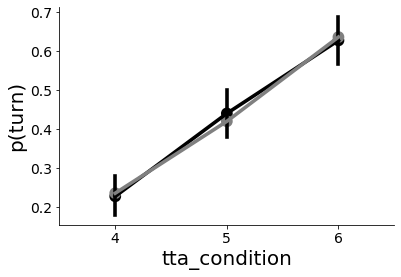

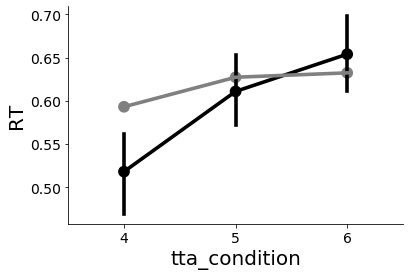

In [266]:
plot_comparison(exp_data, fit_model)

# Custom simulation

In [56]:
def run_trial(condition, params, random_increments, n, t_max=4, dt=0.0001):
    tta_condition, distance_condition = condition
    alpha, boundary, tta_crit = params
    nondecision_time = 0.0
    
    t_values = np.arange(0, t_max, dt)
    drift_rate_values = np.zeros_like(t_values)
    evidence_values = np.zeros_like(t_values)
    
    for i, t in enumerate(t_values[1:]):
        current_tta = tta_condition-t
        drift_rate = alpha*(current_tta-tta_crit)
        evidence = (evidence_values[i] + drift_rate*dt + random_increments[i] 
                    if t>nondecision_time else 0)
        
        drift_rate_values[i+1] = drift_rate
        evidence_values[i+1] = evidence
            
        if (abs(evidence) > boundary):
            break
        
    is_turn_decision = (evidence > boundary)
        
    return pd.DataFrame(data={'n': n,
                              't': t_values[:i+2],
                              'x': evidence_values[:i+2],
                              'd': drift_rate_values[:i+2],
                              'is_turn_decision': is_turn_decision})   

def run_sim(condition, params, n_sim=1000, t_max=4, dt=0.0001):
    random_increments = np.random.randn(n_sim, int(t_max/dt))*np.sqrt(dt)
    trials = [run_trial(condition, params, random_increments[n], n, t_max, dt) for n in range(n_sim)]
    sim_result = pd.concat(trials).set_index(['n'])
    tta, distance = condition
    sim_result['tta_condition'] = tta
    sim_result['d_condition'] = distance
    
    return sim_result 

def get_model_sim_results(params):  
    return pd.concat([run_sim(condition=(tta, 90), params=params) for tta in [4, 5, 6]])

In [55]:
def plot_comparison(exp_measures, sim_measures):
    ax = sns.pointplot(data=exp_measures, x='tta_condition', y='is_turn_decision', marker='o', color='k', ls='-')
    sns.pointplot(ax=ax, data=sim_measures, x='tta_condition', y='is_turn_decision', marker='o', color='grey')
    ax.set_ylabel('p(turn)')
    plt.figure()
    ax = sns.pointplot(data=exp_measures[exp_measures.is_turn_decision], 
                       x='tta_condition', y='RT', marker='o', color='k', ls='-')
    sns.pointplot(ax=ax, data=sim_measures[sim_measures.is_turn_decision], 
                  x='tta_condition', y='RT', marker='o', color='grey')
    
def plot_ddm_traces(sim_data, axes=None):
    turn_rate = sim_data.groupby('n').is_turn_decision.last().mean()
    mean_turn_rt = sim_data[sim_data.is_turn_decision].groupby('n').t.last().mean()
    
    if axes is None:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4), sharex=True)
        axes = (ax1, ax2, ax3)
    else:
        (ax1, ax2, ax3) = axes
     
    for n, traj in sim_data.groupby('n'):
        is_turn_decision = traj.is_turn_decision.iloc[-1]
        color = 'C1' if is_turn_decision else 'C2'
        alpha = 0.3 if is_turn_decision else 0.1
        ax1.plot(traj.t, traj.x, color=color, alpha=alpha)
        ax2.plot([traj.t.values[-1]], [traj.d.values[-1]], color=color, marker='o', alpha=alpha)
    
    response_times = sim_data[sim_data.is_turn_decision].groupby('n').t.last()
    sns.kdeplot(ax=ax3, data=response_times, color='C1', shade=True, legend=False)
    
    for ax in axes:
        ax.set_xlim((0, response_times.max()))

    ax1.set_ylabel('evidence $x$')
    ax2.set_ylabel('$tta-tta_{crit}$')
    ax3.set_ylabel('probability')    
    
    ax1.set_xlabel('time $t$')
    ax2.set_xlabel('time $t$')
    ax3.set_xlabel('RT')
    
    ax2.set_title('Turn rate$=%.f\%%$, mean turn RT $=%.2f$s' % (100*turn_rate, mean_turn_rt))
    plt.subplots_adjust(hspace=0.2)
    sns.despine(trim=True, offset=5)
    
    return axes

Wall time: 1min


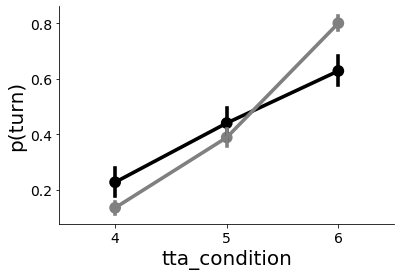

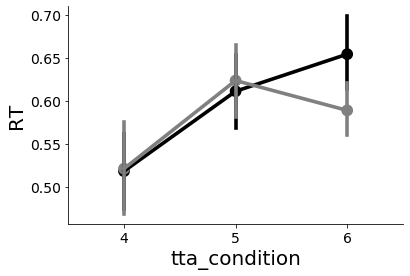

In [57]:
%time sim_results = get_model_sim_results(params=(1,1,4.5))
sim_measures = (sim_results.groupby(['tta_condition', 'n']).last().reset_index()
                .rename(columns={'t': 'RT'}).drop(columns=['n', 'x', 'd']))
exp_measures = pd.read_csv('measures.csv')
plot_comparison(exp_measures, sim_measures)

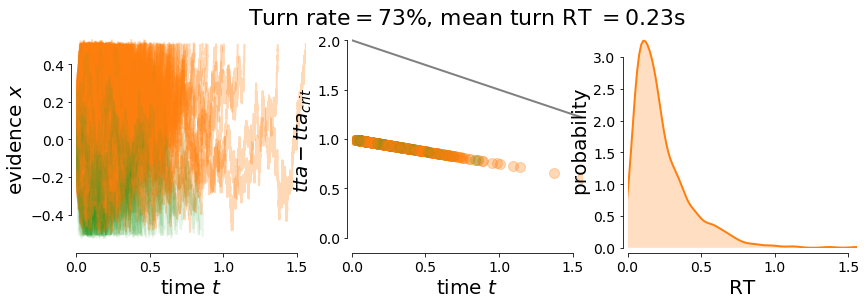

In [46]:
plot_ddm_traces(sim_results[sim_results.tta_condition==4]);

In [141]:
def model_error_wls_per_condition(sim_measures, exp_measures):
    # weighted least squares fitting, as described in Ratcliff & Tuerlinckx 2002   
    p_exp = exp_measures.is_turn_decision.mean()
    p_model = sim_measures.is_turn_decision.mean()
    delta_p = (p_model - p_exp)**2

    rt_quantiles = [0.1, 0.3, 0.5, 0.7, 0.9]
    rt_q_weights = [2, 2, 1, 1, 0.5]
    
    model_rt_quantiles = sim_measures[sim_measures.is_turn_decision].RT.quantile(rt_quantiles)
    exp_rt_quantiles = exp_measures[exp_measures.is_turn_decision].RT.quantile(rt_quantiles)    
    
    return 4*delta_p + np.dot((model_rt_quantiles-exp_rt_quantiles)**2, rt_q_weights)*p_exp

def model_error_wls(sim_measures, exp_measures):
    error = [model_error_wls_per_condition(sim_measures[sim_measures.tta_condition==tta],
                                           exp_measures[exp_measures.tta_condition==tta]) for tta in [4, 5, 6]]
    return sum(error)

def f_wls(params):    
    exp_measures = pd.read_csv('measures.csv')
    sim_results = get_model_sim_results(params)
    sim_measures = (sim_results.groupby(['tta_condition', 'n']).last().reset_index()
                    .rename(columns={'t': 'RT'}).drop(columns=['n', 'x', 'd']))
    f = model_error_wls(sim_measures, exp_measures)
    print(f, params)
    return f

In [65]:
# alpha, boundary, tta_crit = params
ranges = (slice(0.1, 3.2, 1.0), slice(0.1, 3.2, 1.0), slice(4.0, 5.1, 0.5))
%time params_opt, fval, grid, jout = optimize.brute(f_wls, ranges=ranges, Ns=2, full_output=True, finish=None)

2.787442727819862
2.783386489843026
2.8332460458188757
1.6485192251859284
1.9179245828287628
1.7360595502260614
13.860893945353602
13.566686608641302
13.834017791780667
28.168151934621545
29.747443670987792
28.21839090300231
2.793772186940395
2.734440521313453
2.713832849598502
0.6678972157909966
0.37700493750527886
0.5249226255777395
1.6950880536775315
2.4186959848325866
2.5030809990488336
nan
nan
nan
2.880906686793896
2.685083521153019
2.5770801646664134
1.5250714931285358
1.0190486002103278
0.9609450879485784
0.9567267518226564
nan
nan
nan
nan
nan
3.049041003695492
2.6992237470908336
2.515207890474943
2.280203290332218
1.3720435918194673
nan
nan
nan
nan
nan
nan
nan
Wall time: 1h 26min 52s


In [142]:
i, j, k = np.unravel_index(np.nanargmin(jout), jout.shape)
params_opt = [grid[0][i][0][0], grid[1][0][j][0], grid[2][0][0][k]] 
%time f_wls(params_opt)

0.3547671013430629 [1.1, 1.1, 4.5]
Wall time: 1min 18s


0.3547671013430629

* Threshold on noisy percept of tau-tau_crit + non-decision time
* DDM with linearly collapsing bound
* DDM with exponentially collapsing bound    